In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class BayesianQubitRegressor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=2, dropout_rate=0.2):
        super(BayesianQubitRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.output(x)
        return out

In [3]:
# Load saved weights into new model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BayesianQubitRegressor().to(device)
model.load_state_dict(torch.load("bnn_qubit_model.pth", map_location=device))
model.eval()  
print("Model loaded successfully.")

Model loaded successfully.


In [4]:
# Load CSV again and recreate test set

df = pd.read_csv("qubit_measurements.csv")

# Split into inputs and targets
X = df[['sigma_x', 'sigma_y', 'sigma_z']].values
y = df[['theta', 'phi']].values

# Same train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [5]:
# Run multiple forward passes with dropout ON

def mc_dropout_predict(model, inputs, num_samples=100):
    """
    Runs multiple stochastic forward passes to estimate uncertainty.

    Args:
        model: trained BNN model
        inputs: tensor of shape (batch_size, 3)
        num_samples: number of stochastic passes to run

    Returns:
        all_preds: array of shape (num_samples, batch_size, 2)
    """
    model.train()  

    preds = []

    for _ in range(num_samples):
        with torch.no_grad():
            output = model(inputs)  # shape: (batch_size, 2)
            preds.append(output.cpu().numpy())

    # Stack into shape (num_samples, batch_size, 2)
    all_preds = np.stack(preds)

    return all_preds

In [6]:
# N test samples
N = 10
num_mc_samples = 100

# inputs and ground truth
x_sample = X_test_tensor[:N]
y_true = y_test_tensor[:N].cpu().numpy()

# MC Dropout sampling
predictions = mc_dropout_predict(model, x_sample, num_samples=num_mc_samples)

# predictions shape: (100 samples, 5 inputs, 2 outputs)
print("MC samples shape:", predictions.shape)

MC samples shape: (100, 10, 2)


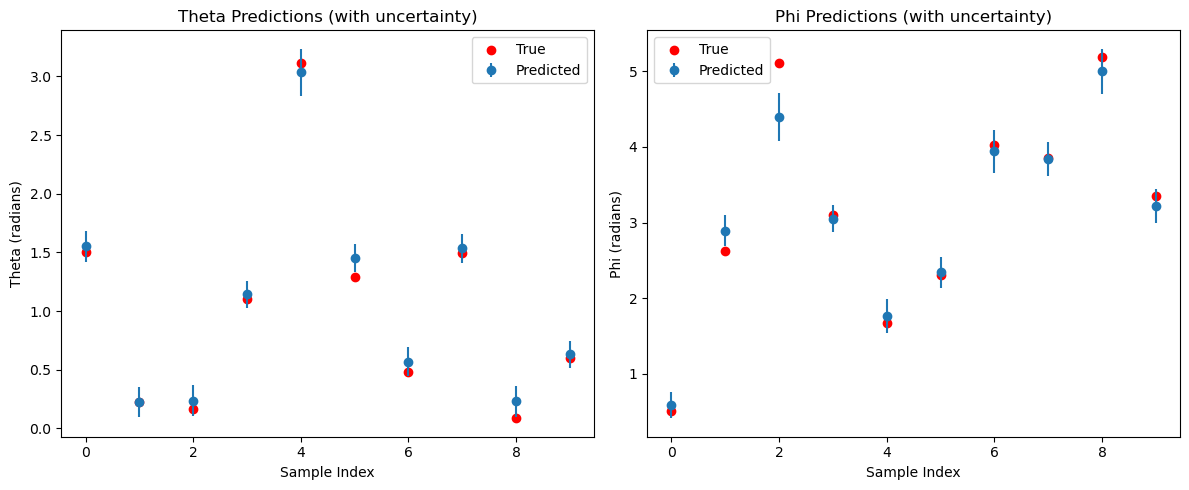

In [ ]:
# Mean + Std prediction plots

# mean and standard deviation over MC samples
# Shape: (batch_size, 2)
means = predictions.mean(axis=0)
stds = predictions.std(axis=0)

# mean theta and phi separately
theta_mean = means[:, 0]
phi_mean = means[:, 1]

theta_std = stds[:, 0]
phi_std = stds[:, 1]

# ground truth
theta_true = y_true[:, 0]
phi_true = y_true[:, 1]

# -------------------------------
# Plot predictions vs true values with error bars
# -------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

x = np.arange(len(theta_mean))  

# theta predictions
axs[0].errorbar(x, theta_mean, yerr=theta_std, fmt='o', label='Predicted')
axs[0].scatter(x, theta_true, color='red', label='True')
axs[0].set_title('Theta Predictions (with uncertainty)')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Theta (radians)')
axs[0].legend()

# phi predictions
axs[1].errorbar(x, phi_mean, yerr=phi_std, fmt='o', label='Predicted')
axs[1].scatter(x, phi_true, color='red', label='True')
axs[1].set_title('Phi Predictions (with uncertainty)')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Phi (radians)')
axs[1].legend()

plt.tight_layout()
plt.show()

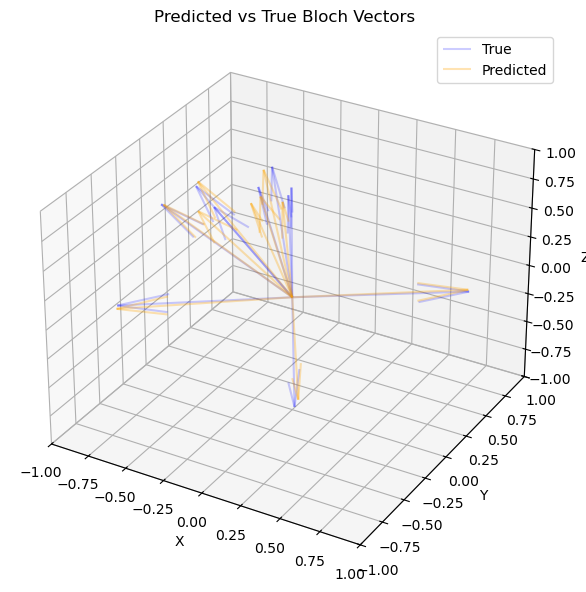

In [8]:
# Convert theta, phi to Bloch vectors (true and predicted)
def bloch_vector(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

# N test points
N = 200
theta_pred = predictions.mean(axis=0)[:N, 0]
phi_pred   = predictions.mean(axis=0)[:N, 1]

theta_true = y_true[:N, 0]
phi_true   = y_true[:N, 1]

# Convert to Bloch coordinates
x_pred, y_pred, z_pred = bloch_vector(theta_pred, phi_pred)
x_true, y_true, z_true = bloch_vector(theta_true, phi_true)

# true vs predicted Bloch vectors
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# True state arrows (blue)
ax.quiver(0, 0, 0, x_true, y_true, z_true, length=1, color='blue', alpha=0.2, label='True')

# Predicted state arrows (orange)
ax.quiver(0, 0, 0, x_pred, y_pred, z_pred, length=1, color='orange', alpha=0.3, label='Predicted')

# Formatting
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Predicted vs True Bloch Vectors')
ax.legend()
plt.tight_layout()
plt.show()

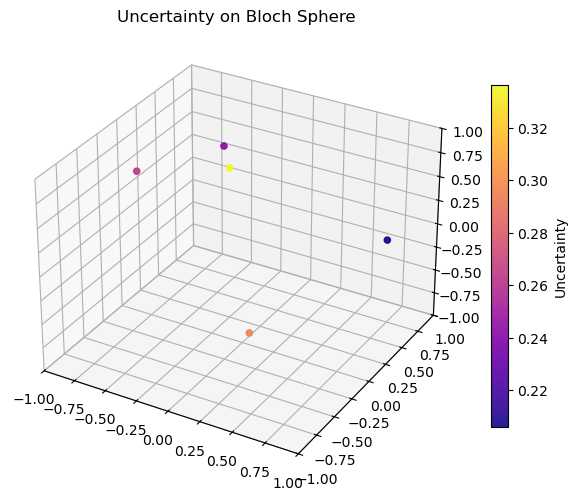

In [9]:
# Standard deviation per point
theta_std = predictions.std(axis=0)[:N, 0]
phi_std = predictions.std(axis=0)[:N, 1]

# Combine std into a "total uncertainty"
uncertainty = np.sqrt(theta_std**2 + phi_std**2)

# Convert mean predictions to Bloch points
x, y, z = bloch_vector(theta_pred, phi_pred)

# Plot points with uncertainty as color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=uncertainty, cmap='plasma', alpha=0.9)
plt.colorbar(sc, shrink=0.6, label='Uncertainty')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_title('Uncertainty on Bloch Sphere')
plt.tight_layout()
plt.show()

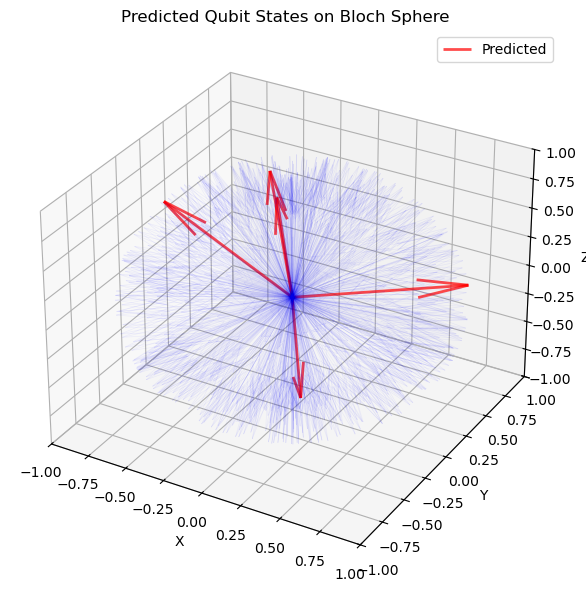

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Convert theta and phi to Bloch coordinates (already defined earlier)
def bloch_vector(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

# True vectors from full dataset (subset for clarity)
theta_all = df['theta'].values
phi_all = df['phi'].values
x_true, y_true, z_true = bloch_vector(theta_all, phi_all)

# Predicted vectors from MC mean
N = 300  # limit how many predicted vectors we show
theta_pred = predictions.mean(axis=0)[:N, 0]
phi_pred   = predictions.mean(axis=0)[:N, 1]
x_pred, y_pred, z_pred = bloch_vector(theta_pred, phi_pred)

# --------------------------
# Plot
# --------------------------
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Light background layer: true states
ax.quiver(0, 0, 0, x_true[:1000], y_true[:1000], z_true[:1000],
          length=1, color='blue', alpha=0.05, linewidth=0.5)

# Highlight layer: bold red predicted states
ax.quiver(0, 0, 0, x_pred, y_pred, z_pred,
          length=1, color='red', alpha=0.7, linewidth=2.0, label='Predicted')

# Formatting
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Predicted Qubit States on Bloch Sphere')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# dropout at test time
model.train()

# index of test sample
idx = 0

# T stochastic forward passes for one test point
T = 100
x_sample = torch.from_numpy(X_test[idx]).float().unsqueeze(0)
theta_preds = []

with torch.no_grad():
    for _ in range(T):
        output = model(x_sample)  # shape: [1, 2] — predicting [theta, phi]
        theta_preds.append(output[0, 0].item())  

theta_preds = np.array(theta_preds)

# posterior histogram
true_theta = y_test[idx, 0].item()

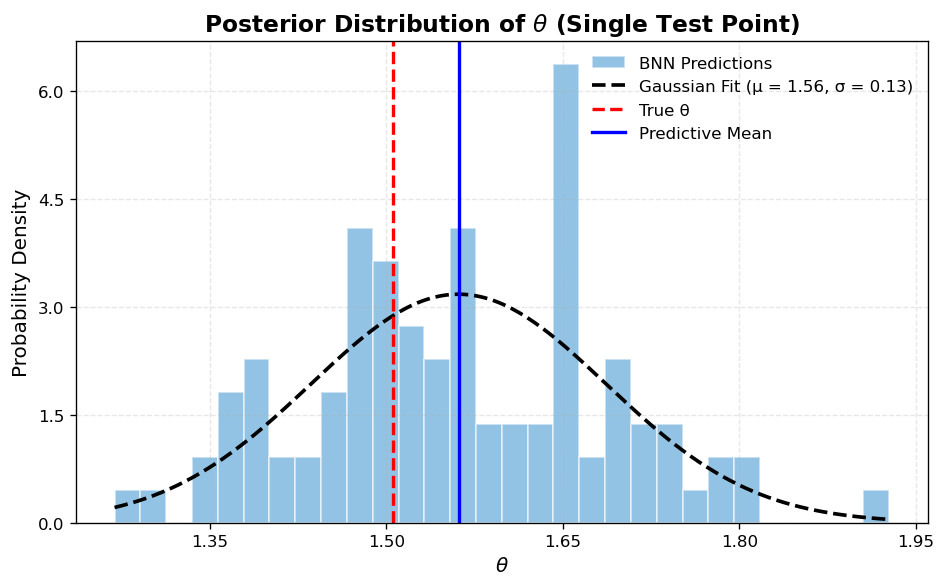

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.ticker as ticker

# theta_preds: numpy array of shape (T,) from MC Dropout
# true_theta: scalar ground truth value for θ

# Gaussian distribution to BNN predictions
mu, std = norm.fit(theta_preds)

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

# Histogram of theta predictions
ax.hist(theta_preds, bins=30, density=True, alpha=0.6, color='#4B9CD3', edgecolor='white', label='BNN Predictions')

# Gaussian PDF overlay
x = np.linspace(min(theta_preds), max(theta_preds), 200)
pdf = norm.pdf(x, mu, std)
ax.plot(x, pdf, 'k--', linewidth=2.2, label='Gaussian Fit (μ = {:.2f}, σ = {:.2f})'.format(mu, std))

# Vertical lines for mean and true value
ax.axvline(true_theta, color='red', linestyle='--', linewidth=2, label='True θ')
ax.axvline(mu, color='blue', linestyle='-', linewidth=2, label='Predictive Mean')

ax.set_title(r'Posterior Distribution of $\theta$ (Single Test Point)', fontsize=14, weight='bold')
ax.set_xlabel(r'$\theta$', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.legend(fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

In [14]:
import torch
import numpy as np

# dropout at test time
model.train()

# index of test sample
idx = 0
x_sample = torch.from_numpy(X_test[idx]).float().unsqueeze(0)  # Shape: [1, features]
T = 100  # Number of stochastic forward passes

phi_preds = []

with torch.no_grad():
    for _ in range(T):
        output = model(x_sample)  # Shape: [1, 2] — output: [theta, phi]
        phi_preds.append(output[0, 1].item())  

# Convert to numpy array
phi_preds = np.array(phi_preds)

# true phi value
true_phi = y_test[idx, 1].item()

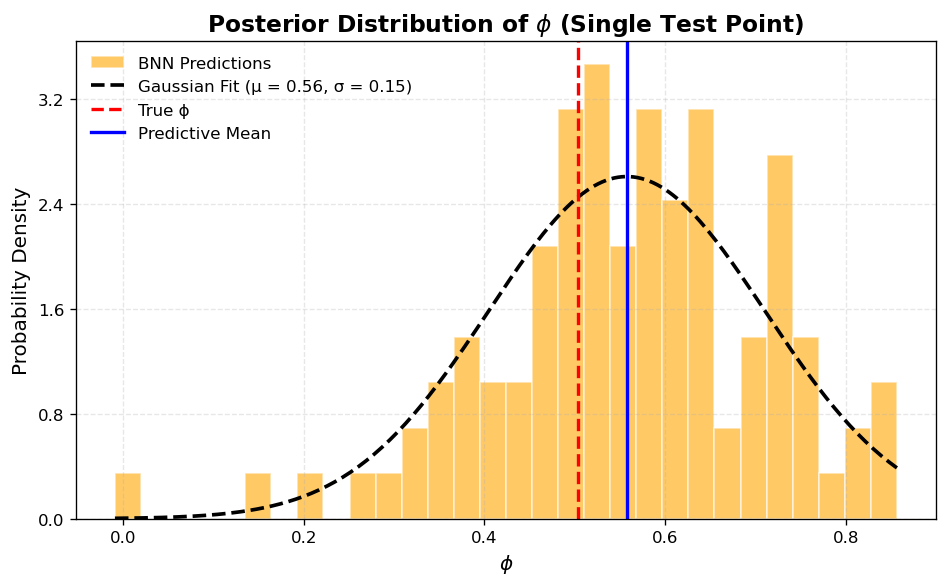

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.ticker as ticker

# Gaussian distribution to BNN predictions
mu, std = norm.fit(phi_preds)

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

# Histogram of phi predictions
ax.hist(phi_preds, bins=30, density=True, alpha=0.6, color='#FFA500', edgecolor='white', label='BNN Predictions')

# Gaussian PDF overlay
x = np.linspace(min(phi_preds), max(phi_preds), 200)
pdf = norm.pdf(x, mu, std)
ax.plot(x, pdf, 'k--', linewidth=2.2, label='Gaussian Fit (μ = {:.2f}, σ = {:.2f})'.format(mu, std))

# Vertical lines for mean and true value
ax.axvline(true_phi, color='red', linestyle='--', linewidth=2, label='True ϕ')
ax.axvline(mu, color='blue', linestyle='-', linewidth=2, label='Predictive Mean')

ax.set_title(r'Posterior Distribution of $\phi$ (Single Test Point)', fontsize=14, weight='bold')
ax.set_xlabel(r'$\phi$', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.legend(fontsize=10, frameon=False)

plt.tight_layout()
plt.show()